## 영화 추천 시스템(Session_based_RNN) 

### 세션  
>Session은 인터넷을 이용할 때 이용자와 관계된 개인에 민감한 정보를 관리자측에서 저장하고 관리해준다  

따라서 세션을 이용한다면 이용자가 어떤 물건, 서비스 등을 이용했는지 파악하고 그와 관련해 이용자가 원하거나 이용자에게 알맞는 추천을 해줄 수 있을 것이다.

## 라이브러리 

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data.head(5)


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


해당 데이터에는 세션에 관한 데이터가 존재하지 않는다. 하지만 UserId 칼럼이 있기 때문에   
이를 대신 활용할 수 있을 것이다.

In [3]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


Time 칼럼의 데이터가 9~~ 와 같은 형태로 저장되어 있다. 이는 UTC time이 포함된 1970/1/1부터 경과된 시간이 초 단위로 기재되어 있다(유닉스 타임이라고 한다). 이를 처리하기 위해서 시간 단위를 바꿔줘야한다.

In [4]:
times = data["Time"] 
time_list = [] 
for time in times: 
    temp = dt.datetime.fromtimestamp(time) #해당 메소드를 이용하면 유닉스 타임을 바꿔줄 수 있다.
    time_list.append(temp)

data["Time"] = time_list
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [6]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

session_length는 같은 UserId를 공유하는 데이터 칼럼의 개수를 의미한다.  
session_length를 통해서 한 아이디가 어떤 곳에 수 개의 리뷰를 다는 행위나 비정상적인  
행위를 포착할 수 있을 것이다.

In [7]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [8]:
session_length.min(), session_length.max()

(20, 2314)

In [9]:
session_length.quantile(0.999)

1343.181000000005

In [10]:
long_session = session_length[session_length==session_length.max()].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-04 05:09:52
697168,4169,2617,4,2000-08-04 05:09:52
697185,4169,2628,4,2000-08-04 05:09:52
697219,4169,2653,4,2000-08-04 05:09:52
697275,4169,423,3,2000-08-04 05:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-16 05:52:27
695702,4169,1413,3,2002-06-16 06:03:51
697358,4169,494,4,2002-06-16 06:16:00
695945,4169,1804,2,2002-06-16 06:16:23


In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

비 정상적인 행위를 포착하기 위해 데이터를 시각화 한다.

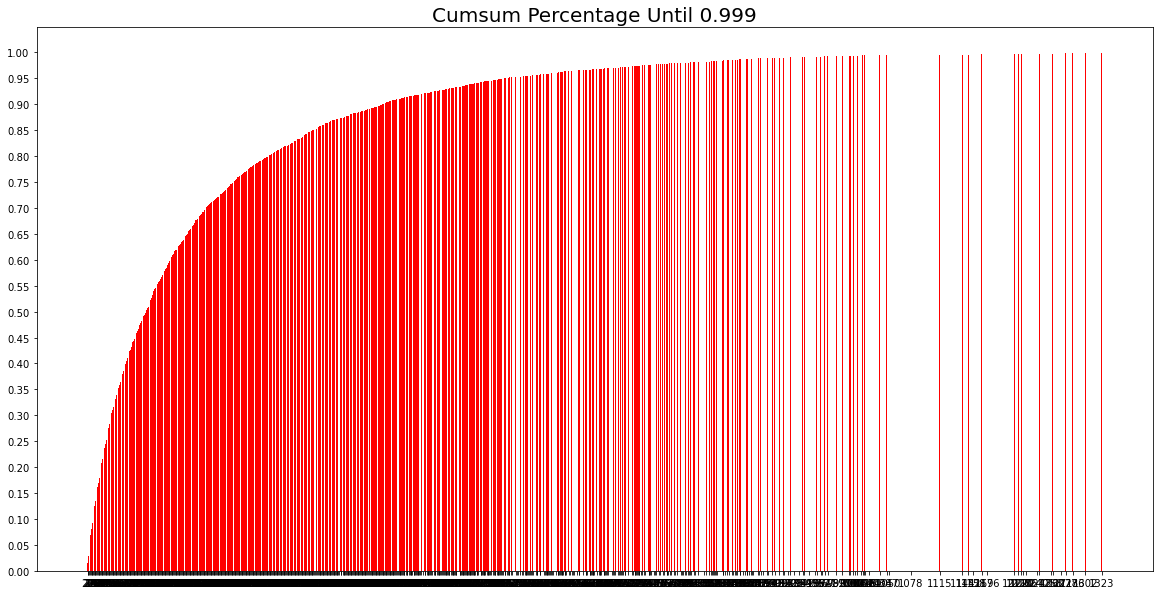

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


### Data Cleansing

데이터가 1개 이하라면 다음 예측을 하는데 문제를 끼칠 수 있다.  
따라서 1개 이하 이거나 점수를 준 회수가 너무 적은 user는 제거한다.

In [14]:

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
data = cleanse_recursive(data, shortest=100,least_click=100)
len(data)

775176

날짜에 따라서 validation set과 test set을 나눠줄 수 있는 함수를 구현한다.

In [16]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [17]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [18]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [19]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 706067
	 Sessions: 2671
	 Items: 1919
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-12-30 11:26:14

* valid Set Stats Info
	 Events: 28187
	 Sessions: 69
	 Items: 1918
	 First Time : 2000-05-06 02:20:21
	 Last Time : 2003-01-29 12:00:40

* test Set Stats Info
	 Events: 40922
	 Sessions: 88
	 Items: 1918
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



In [20]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [21]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data Pipeline 

### minibatch 

userId의 길이는 꽤 긴 것들로 되어있는데, 이를 mini-batch로 구성하여 input으로 넣으면, 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들을 기다린다.  
하지만 GRU4REC 논문에서는 Session-Paralle Mini-Batches를 제안한다 이는 Mini-batch의 병렬계산을 의미한다.

데이터가 주어졌을 때 userid의 인덱스를 담는 값과 이를 새로 인덱싱한 값을 갖는 클래스를 만들어 준다.

In [22]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [23]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
170,2,2943,4,2001-01-01 06:32:52,5
106,2,1225,5,2001-01-01 06:33:11,6
120,2,1193,5,2001-01-01 06:33:33,7
172,2,318,5,2001-01-01 06:33:33,8
70,2,3030,4,2001-01-01 06:33:54,9


In [24]:
tr_dataset.click_offsets

array([     0,    125,    297, ..., 705636, 705754, 706067], dtype=int32)

In [25]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2668, 2669, 2670])

위에서 만들어준 객체를 통해 mini-batch를 만드는 클래스를 만들어준다.

In [26]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [27]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
170,2,2943,4,2001-01-01 06:32:52,5
106,2,1225,5,2001-01-01 06:33:11,6
120,2,1193,5,2001-01-01 06:33:33,7
172,2,318,5,2001-01-01 06:33:33,8
70,2,3030,4,2001-01-01 06:33:54,9


In [28]:
iter_ex = iter(tr_data_loader)

In [29]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0   3   1 354]
Label Item Idx are :       [  1 125 277 355]
Previous Masked Input Idx are []


## Modeling 

GRU(Gated Recurrent Unit)을 이용한 모델을 만들어준다.  

In [30]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [32]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [33]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz#유닛
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k#아이템의 개수

args = Args(tr, val, test, batch_size=64, hsz=30, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [34]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 1919)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 30), (64, 30)]      175590    
_________________________________________________________________
dropout (Dropout)            (64, 30)                  0         
_________________________________________________________________
dense (Dense)                (64, 1919)                59489     
Total params: 235,079
Trainable params: 235,079
Non-trainable params: 0
_________________________________________________________________


## Training 

In [35]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [36]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.77]

	 - Recall@20 epoch 1: 0.222195
	 - MRR@20    epoch 1: 0.054913



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.25]

	 - Recall@20 epoch 2: 0.277682
	 - MRR@20    epoch 2: 0.073959



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.21]

	 - Recall@20 epoch 3: 0.295645
	 - MRR@20    epoch 3: 0.082957



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.109, train_loss=4.87] 

	 - Recall@20 epoch 4: 0.305733
	 - MRR@20    epoch 4: 0.088028



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.16]

	 - Recall@20 epoch 5: 0.309916
	 - MRR@20    epoch 5: 0.091351



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.24]

	 - Recall@20 epoch 6: 0.315822
	 - MRR@20    epoch 6: 0.094130



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.03]

	 - Recall@20 epoch 7: 0.317913
	 - MRR@20    epoch 7: 0.095499



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.09]

	 - Recall@20 epoch 8: 0.319267
	 - MRR@20    epoch 8: 0.095634



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.08]

	 - Recall@20 epoch 9: 0.319144
	 - MRR@20    epoch 9: 0.096039



Evaluation:  29%|██▉       | 127/439 [00:22<00:54,  5.74it/s]

	 - Recall@20 epoch 10: 0.321112
	 - MRR@20    epoch 10: 0.096459



In [39]:
args2 = Args(tr, val, test, batch_size = 32 ,hsz=30, drop_rate = 0.1, lr = 0.001, epochs = 10, k = 20)
model_2 = create_model(args2)
train_model(model_2,args2)

Train:   0%|          | 0/21981 [00:00<?, ?it/s]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 1919)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 30), (32, 30)]      175590    
_________________________________________________________________
dropout_2 (Dropout)          (32, 30)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 1919)                59489     
Total params: 235,079
Trainable params: 235,079
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0, train_loss=5.67]     

	 - Recall@20 epoch 1: 0.210266
	 - MRR@20    epoch 1: 0.053307



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.55]

	 - Recall@20 epoch 2: 0.252582
	 - MRR@20    epoch 2: 0.067652



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.32]

	 - Recall@20 epoch 3: 0.267548
	 - MRR@20    epoch 3: 0.072638



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.49]

	 - Recall@20 epoch 4: 0.276929
	 - MRR@20    epoch 4: 0.076749



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.3] 

	 - Recall@20 epoch 5: 0.278088
	 - MRR@20    epoch 5: 0.078902



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.37]

	 - Recall@20 epoch 6: 0.280618
	 - MRR@20    epoch 6: 0.080531



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.28]

	 - Recall@20 epoch 7: 0.282462
	 - MRR@20    epoch 7: 0.081669



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.36]

	 - Recall@20 epoch 8: 0.282251
	 - MRR@20    epoch 8: 0.081836



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.99]

	 - Recall@20 epoch 9: 0.283674
	 - MRR@20    epoch 9: 0.082016



Evaluation:  68%|██████▊   | 593/878 [00:57<00:27, 10.25it/s]

	 - Recall@20 epoch 10: 0.285255
	 - MRR@20    epoch 10: 0.082118



In [40]:
args3 = Args(tr, val, test, batch_size = 64,hsz=64, drop_rate = 0.1, lr = 0.001, epochs = 10, k = 10)
model_3 = create_model(args3)
train_model(model_3,args3)

Train:   0%|          | 0/10990 [00:00<?, ?it/s]

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 1919)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 64), (64, 64)]      381120    
_________________________________________________________________
dropout_3 (Dropout)          (64, 64)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 1919)                124735    
Total params: 505,855
Trainable params: 505,855
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.35]

	 - Recall@10 epoch 1: 0.171998
	 - MRR@10    epoch 1: 0.063911



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.14]

	 - Recall@10 epoch 2: 0.200418
	 - MRR@10    epoch 2: 0.079944



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5]   

	 - Recall@10 epoch 3: 0.216535
	 - MRR@10    epoch 3: 0.088246



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.05]

	 - Recall@10 epoch 4: 0.222933
	 - MRR@10    epoch 4: 0.092793



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.93]

	 - Recall@10 epoch 5: 0.228469
	 - MRR@10    epoch 5: 0.095900



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.87]

	 - Recall@10 epoch 6: 0.228593
	 - MRR@10    epoch 6: 0.096315



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.109, train_loss=4.87] 

	 - Recall@10 epoch 7: 0.232283
	 - MRR@10    epoch 7: 0.096700



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.93]

	 - Recall@10 epoch 8: 0.231299
	 - MRR@10    epoch 8: 0.097332



Train:   0%|          | 0/10990 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.94]

	 - Recall@10 epoch 9: 0.230561
	 - MRR@10    epoch 9: 0.098424



Evaluation:  29%|██▉       | 127/439 [00:14<00:35,  8.69it/s]

	 - Recall@10 epoch 10: 0.230069
	 - MRR@10    epoch 10: 0.097932



In [41]:
args4 = Args(tr, val, test, batch_size=32,hsz=15, drop_rate=0.1, lr = 0.001, epochs = 10, k = 20)
model_4 = create_model(args4)
train_model(model_4,args4)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 1, 1919)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 15), (32, 15)]      87120     
_________________________________________________________________
dropout_4 (Dropout)          (32, 15)                  0         
_________________________________________________________________
dense_4 (Dense)              (32, 1919)                30704     
Total params: 117,824
Trainable params: 117,824
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.88]

	 - Recall@20 epoch 1: 0.172218
	 - MRR@20    epoch 1: 0.041310



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.61]

	 - Recall@20 epoch 2: 0.223493
	 - MRR@20    epoch 2: 0.055424



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.12]

	 - Recall@20 epoch 3: 0.241568
	 - MRR@20    epoch 3: 0.061657



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.54]

	 - Recall@20 epoch 4: 0.250790
	 - MRR@20    epoch 4: 0.064584



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.52]

	 - Recall@20 epoch 5: 0.253583
	 - MRR@20    epoch 5: 0.066649



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.48]

	 - Recall@20 epoch 6: 0.257799
	 - MRR@20    epoch 6: 0.067750



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0, train_loss=5.51]     

	 - Recall@20 epoch 7: 0.262489
	 - MRR@20    epoch 7: 0.069445



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.45]

	 - Recall@20 epoch 8: 0.263175
	 - MRR@20    epoch 8: 0.070213



Train:   0%|          | 0/21981 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.55]

	 - Recall@20 epoch 9: 0.263438
	 - MRR@20    epoch 9: 0.070511



Evaluation:  68%|██████▊   | 593/878 [00:59<00:28, 10.04it/s]

	 - Recall@20 epoch 10: 0.264387
	 - MRR@20    epoch 10: 0.071668



## Inference 

In [42]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  46%|████▌     | 291/638 [00:51<01:01,  5.65it/s]

	 - Recall@20: 0.321682
	 - MRR@20: 0.094666



In [44]:
test_model(model_2, args2, test)

Evaluation:  80%|███████▉  | 1019/1276 [01:40<00:25, 10.11it/s]

	 - Recall@20: 0.272448
	 - MRR@20: 0.078020



In [45]:
test_model(model_3, args3, test)

Evaluation:  46%|████▌     | 291/638 [00:50<01:00,  5.76it/s]

	 - Recall@10: 0.335159
	 - MRR@10: 0.101162



In [46]:
test_model(model_4, args4, test)

Evaluation:  80%|███████▉  | 1019/1276 [01:41<00:25, 10.04it/s]

	 - Recall@20: 0.252576
	 - MRR@20: 0.067735

